In [1]:
import requests
import time
import os
import sys
import re
import io
import json
import csv
import openpyxl
import pandas as pd
import numpy as np
import kss
import ast
from pykospacing import spacing
from konlpy.tag import Komoran

In [2]:
#각 키워드에 해당하는 내용 정리
#예시: ['간부', '군대', '기부', '나라', '백신', '병원', '수술', '아웃', '추신수', '후원']
from IPython.core.display import display, HTML
from konlpy.tag import Okt

#키워드에 해당하는 제목, 본문, 댓글 출력, 추후 iteration 돌며 10가지 모두 할 것
key = '후원'

final = pd.DataFrame(columns = ['contents'])

f = pd.read_csv('fm_엑셀확인용.csv')

is_key = f['본문'].str.contains(key, na=False) | f['제목'].str.contains(key, na=False) | f['댓글'].str.contains(key, na=False)

f_key = f[is_key]
f_key = f_key.reset_index()
f_key

,index,제목,본문,댓글
0,5,오늘자 콜센터 상담사의 외 침,한남들 후원 취소하는 거 타격 도 없으니까 홈페이지로 취소 문의 넣어 달래,저런 거 보면 그냥 장작 넣을려고 위장 같음 드가 자쟤는 초록우산 측에서 백퍼 고소...
1,7,이 기적인 한남들 기부해봐야 얼마나 한다고,요즘 핫한 초록우산 페미 지원 뉴스베댓 한남들에게 일 침 남자 놈들 기부 해봐야 얼...,솔직히 말해서 여초애들이 후원을 하겠냐고 족보세트 하나라 더 시켜 먹으려고 할 건데...
2,9,초록우산 문의 답변 받음,내가 초록우산 한 년 넘게 후원하고 있는데 어제 초록우산 관련 글 보고 바로 문의 ...,그 디씨에 올라온 상담사 글이 일 수도 있겠네 한 남꺼져 이거구만 후원자가 하는 질...


In [3]:
final_key = pd.DataFrame(columns = ['tokenized'])
komoran = Komoran()

for i in range(len(f_key)):
    try:
        st = f_key.loc[i, '제목']
        final_key.loc[i, 'tokenized'] = st
        ct = f_key.loc[i, '본문']
        final_key.loc[i, 'tokenized'] += ct
        
        cm = f_key.loc[i, '댓글']
        #str Concatenation 문제 발생시 주석처리한 부분처럼 str() 처리하면 해결 가능
        final_key.loc[i, 'tokenized'] += cm
        #final_key.loc[i, 'tokenized'] += str(cm)
        
    except KeyError:
        print("error")

keyword_content = pd.DataFrame(columns = ['content','positive', 'negative', 'neutral'])


for i in range(len(final_key)):
    try:
        fc = final_key.loc[i, 'tokenized'].replace(" ", "")
        fc = spacing(fc)
        #fc = str(komoran.morphs(fc))
        
        if i == 0:
            keyword_content.loc[0,'content'] = fc
        else:
            keyword_content.loc[0,'content'] += fc
        
    except KeyError:
        print("error")

keyword_content

,content,positive,negative,neutral
0,오늘자 콜센터 상담사의 외침한 남들 후원 취소하는 거 타격도 없으니까 홈페이지로 취...,NaN,NaN,NaN


In [4]:
# 감성사전에서 감성분석
f = open('SentiWord_Dict.txt', 'r', -1, 'utf-8')
lines = f.readlines()

score_dict = []

for line in lines:
    line_splited = line.split()
    score = int(line_splited[-1])
    word = ''
    for frac in line_splited[:-1]:
        word = word + ' ' + frac
    
    word = word[1:]
    score_dict.append([word, score])

In [5]:
#keys = []

keyword_content['positive'] = 0
keyword_content['negative'] = 0
keyword_content['neutral'] = 0

komoran = Komoran()
keys = spacing(keyword_content.loc[0, 'content'])
#keys = str(komoran.nouns(keys))

keyword_content.loc[0, 'content'] = spacing(keyword_content.loc[0, 'content'])
keyword_content.loc[0, 'content'] = str(komoran.nouns(keyword_content.loc[0, 'content']))


stopwords = ['태그', '지원', '으로', '시키다', '브라우저', '새끼', '이랑', '사람', '생각', '정도', '얼굴',
             '섹스', '진짜', '하는', '그냥', '같은', '있는', '이런', '근데', '하고']


pos_list = ast.literal_eval(keyword_content.loc[0, 'content'])
    
final = []
    
for j in range(len(pos_list)):
    if pos_list[j] not in stopwords:
        final.append(pos_list[j])
    
keyword_content.loc[0, 'content'] = str(final)
#keys = str(final)

In [6]:
keyword_content.insert(0, "Keyword", key)

In [7]:
#tokens.append(keyword_content.loc[0, 'content'])
#tokens.extend(keys)

tokens = ast.literal_eval(keyword_content.loc[0, 'content'])

try:
    for token in tokens:
        for dict_word in score_dict:
            if dict_word[0] == token:
                if dict_word[1] > 0:
                    keyword_content.loc[0, 'positive'] += dict_word[1]
                elif dict_word[1] < 0:
                    keyword_content.loc[0, 'negative'] += dict_word[1]
                else:
                    keyword_content.loc[0, 'neutral'] += 1 #중립어는 개수 세기    
except KeyError:
    print("error")

In [8]:
keyword_content[keyword_content.columns.difference(['content'])]

,Keyword,negative,neutral,positive
0,후원,-21,7,18


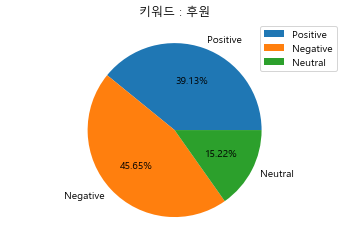

In [9]:
#% 시각화
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager, rc
import platform

#한글 깨짐 처리
if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False
pos = keyword_content.loc[0, 'positive']
neg = str(keyword_content.loc[0, 'negative']).replace("-", "")
neu = keyword_content.loc[0, 'neutral']

size = [pos, neg, neu]

label = ['Positive','Negative','Neutral']

plt.axis('equal')
plt.pie(x=size, labels=label, autopct='%.2f%%')

plt.title("키워드 : " + key)
plt.legend(loc="upper right")
plt.show()
